In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [62]:
from Tire import Tire
from Motor import Motor
from Battery import Battery
from BatteryParams import BatteryParams
from MotorParams import MotorParams
from Motor import Motor
from DriveTrain import DriveTrain
from PID_Controller import PID
from CarParameters import CarParam
from SimulatedCarState import SimulatedCarState
from CarController import CarController
from Control_Response_Evaluator import Control_Response_Evaluator
from Track import Track


plt.rcParams['figure.figsize'] = [10, 7]

c:\Users\sgtas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


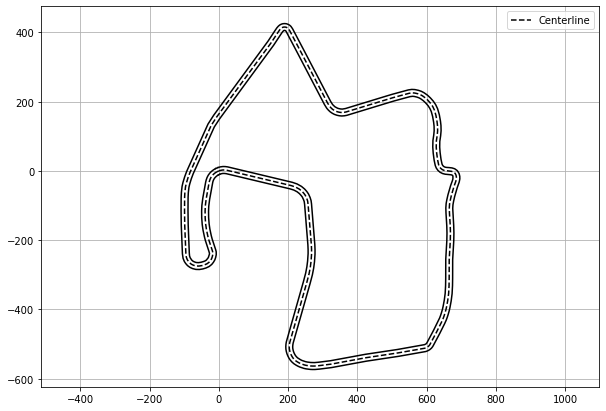

In [63]:
# import track class and data
laguna_seca = "../data/track_data.csv"
test_circle_10m = "../data/test_circle_10.0_radius.csv"
test_circle_50m = "../data/test_circle_50.0_radius.csv"
test_circle_100m = "../data/test_circle_100m_radius.csv"
track = Track(laguna_seca)
track.plot_track()

In [64]:
c1717_1650_params = MotorParams()
c1717_1650_params.name = 'Castle 1717-1650KV'
c1717_1650_params.kv = 1650.0
c1717_1650_params.max_battery_cells = 8.0
c1717_1650_params.max_specd_rpm = 56000.0
c1717_1650_params.resistance = 0.0856092660801802 # pulled from Raz Shifrin's speed secrets via screen capture
c1717_1650_params.diam = 0.0476 # m - 1.87 in
c1717_1650_params.length = 0.0851 # m - 3.35 in
c1717_1650_params.length_scalar_for_fins = 2.0
c1717_1650_params.max_temp = 82.222 # deg C - 180F
c1717_1650_params.specific_heat_coeff = 0.89 # J/(g * deg C) - specific heat capacity of aluminum - 0.385 J/(g * deg C) for copper
c1717_1650_params.mass = 548.0 # grams for Castle Creations 171
c1717_1650_params.print()

MotorParams: Name:  Castle 1717-1650KV
MotorParams: KV:  1650.0
MotorParams: Max Battery Cells:  8.0
MotorParams: Max Voltage:  0.0  V
MotorParams: Max spec'd RPM:  56000.0
MotorParams: KT:  0.0
MotorParams: Resistance:  0.0856092660801802  Ohms
MotorParams: Diameter:  0.0476  m
MotorParams: Length:  0.0851  m
MotorParams: Length Scalar for Fins:  2.0
MotorParams: Max Temp:  82.222  C
MotorParams: Mass:  548.0  g
MotorParams: Specific Heat Coeff:  0.89  J/(g * deg C)


In [65]:
batteryParams = BatteryParams()
battery = Battery()
battery.read_params(batteryParams)
battery.calc_vals()
battery.print()

Battery: Capacity:  8.0
Battery: Max Capacity:  8.0
Battery: Voltage:  4.2
Battery: Max Voltage:  32.8
Battery: Min Voltage:  28.0
Battery: Number of Cells:  8.0
Battery: C Rating:  100.0


In [66]:
class Car:
    motor = Motor()
    battery = Battery()
    driveTrain = DriveTrain()
    controller = CarController()
    state = SimulatedCarState()
    tire = Tire()
    mass = 8.0 # kg
    width = 0.310 # m - 12.2 in
    height = 0.165 # m - 6.5 in
    drag_area_scalar = 0.8 # the car front has holes and is not width * height
    down_force_area_scalar = 0.1 # most of the car isn't pushing down
    frontal_drag_area = width * height * drag_area_scalar # m^2
    frontal_down_force_area = width * height * down_force_area_scalar # m^2
    drag_force = 0.0
    down_force = 0.0
    perp_force = 0.0
    c_d = 0.2 # estimate coefficient of drag
    
    desired_heading = 0.0
    desired_steering = 0.0
    desired_speed = 0.0
    heading_error = 0.0
    steering_error = 0.0
    speed_error = 0.0
    crosstrack_error = 0.0
    
    steering_input = 0.0
    accel_input = 0.0
    
    log_df = pd.DataFrame()
    log_columns = ['Time (s)',
                   'x (m)', 'y (m)', 'z (m)',
                   'xd (m/s)', 'yd (m/s)', 'zd (m/s)',
                   'Speed (m/s)', 'Acceleration (m/s^2)', 'Jerk (m/s^3)',
                   'Heading Angle (rads)', 'Heading Rate (rads/s)',
                   'Steering Angle (rads)', 'Steering Rate (rads/s)',
                   'Down Force (N)', 'Drag Force (N)', 'Perp Force (N)',
                   'Motor Current (A)', 'Motor Voltage (V)',
                   'Motor Speed (rpm)', 'Motor Temp (C)', 'Motor Torque (Nm)',
                   'Battery Capacity (Ah)', 'Battery voltage (V)', 'Battery Capacity (%)',
                   'Drive Train Wheel Force (N)', 'Drive Train Wheel Torque (Nm)', 'Drive Train Wheel Speed (rpm)',
                   'Drive Train Motor Torque (N)', 'Drive Train Motor Speed (rpm)',
                   'Tire Temp (C)',
                   'Desired Steering (rads)', 'Steering Error (rads)', 'Steering Error Sum (rads)', 'Steering Error Rate (rads)',
                   'Steering P-Input', 'Steering I-Input', 'Steering D-Input', 'Steering PID-Input',
                   'Desired Speed (m/s)', 'Speed Error (m/s)', 'Speed Error Sum (m/s)', 'Speed Error Rate (m/s)',
                   'Speed P-Input', 'Speed I-Input', 'Speed D-Input', 'Speed PID-Input',
                   'Desired Crosstrack (m)', 'Crosstrack Error (m)', 'Crosstrack Error Sum (m)', 'Crosstrack Error Rate (m/s)',
                   'Crosstrack P-Input', 'Crosstrack I-Input', 'Crosstrack D-Input', 'Crosstrack PID-Input'
                   ]
    def log_data(self, time):
        # log everything
        data = [[time,
                self.state.x[self.state.xi], self.state.x[self.state.yi], self.state.x[self.state.xi],
                self.state.x[self.state.xdi], self.state.x[self.state.ydi], self.state.x[self.state.xi],
                self.state.x[self.state.fsi], self.state.x[self.state.fai], self.state.x[self.state.fji],
                self.state.x[self.state.hai], self.state.x[self.state.hri],
                self.state.x[self.state.sai], self.state.x[self.state.sri],
                self.down_force, self.drag_force, self.perp_force,
                self.motor.current, self.motor.voltage,
                self.motor.rpm, self.motor.temp, self.motor.torque_Nm,
                self.battery.capacity, self.battery.voltage, self.battery.percent_capacity,
                self.driveTrain.f_wheel, self.driveTrain.t_wheel, self.driveTrain.wheel_rpm,
                self.driveTrain.t_motor, self.driveTrain.motor_rpm,
                self.tire.temp,
                self.controller.steer_pid.s_d, self.controller.steer_pid.s_e, self.controller.steer_pid.error_sum,  self.controller.steer_pid.error_rate,
                self.controller.steer_pid.u_p, self.controller.steer_pid.u_i, self.controller.steer_pid.u_d, self.controller.steer_pid.u,
                self.controller.speed_pid.s_d, self.controller.speed_pid.s_e, self.controller.speed_pid.error_sum,  self.controller.speed_pid.error_rate,
                self.controller.speed_pid.u_p, self.controller.speed_pid.u_i, self.controller.speed_pid.u_d, self.controller.speed_pid.u,
                self.controller.crosstrack_pid.s_d, self.controller.crosstrack_pid.s_e, self.controller.crosstrack_pid.error_sum,  self.controller.crosstrack_pid.error_rate,
                self.controller.crosstrack_pid.u_p, self.controller.crosstrack_pid.u_i, self.controller.crosstrack_pid.u_d, self.controller.crosstrack_pid.u
                ]]
        
        
        if not len(self.log_df.columns):
            self.log_columns
            self.log_df = pd.DataFrame(data, columns=self.log_columns)
        else:
            self.log_df = pd.concat([self.log_df, pd.DataFrame(data, columns=self.log_columns)])

    def calc_drag_force(self, speed, density=1.225):
        # estimate aero drag
        #density = 1.225 # air est
        self.drag_force = 0.5 * density * self.c_d * self.frontal_drag_area * speed**2
        # print("f_drag: ", f_drag, " at ", speed / mph_to_mps)
        return self.drag_force

    def calc_down_force(self, speed, density=1.225):
        # estimate aero down force
        # density = 1.225 # air est
        self.down_force = 0.5 * density * self.c_d * self.frontal_down_force_area * speed**2
        # print("f_drag: ", f_drag, " at ", speed / mph_to_mps)
        return self.down_force

    def update_components(self, air_temp, ground_temp, dt):
        # get forces on car
        fwd_force = self.calc_drag_force(self.state.x[self.state.fsi]) + self.state.x[self.state.fai]
        down_force = self.calc_down_force(self.state.x[self.state.fsi]) + self.mass * 9.81
        perp_force = 0.0 # TODO
        
        # get how those forces affect the tires
        self.tire.update_heat_model([fwd_force, down_force, perp_force], # forces on tires
                                    self.state.x[self.state.fsi], # car speed
                                    self.state.x[self.state.fsi], # air speed
                                    air_temp, # air temp C
                                    ground_temp, # ground temp C
                                    dt)  # time step
        
        # get how those forces affect the motor
        motor_torque = self.driveTrain.calc_motor_torque_from_wheel_force(fwd_force)
        motor_rpm = self.driveTrain.calc_motor_rpm_from_speed_mps(self.state.x[self.state.fsi])
        motor_current = self.motor.calc_current_from_torque(motor_torque, motor_rpm)
        self.motor.update_heat_model(motor_current, # current used
                                     self.state.x[self.state.fsi],# air speed 
                                     air_temp, # air temp 
                                     dt) # seconds

        # get how the motor use affect the batteries
        self.battery.draw_current(motor_current, dt)


x = np.array([track.track_df['x'][0], #0 - x position
                0, #1 - x speed
                track.track_df['y'][0], #2 - y position
                0, #3 - y speed 
                0.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                track.track_df['heading'][0], #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate    

car = Car()
carParams = CarParam()
car.state = SimulatedCarState()
car.state.x = x
car.state.carParams = carParams
car.tire = Tire()
car.tire.calc_values()
car.battery = Battery()
car.battery.read_params(batteryParams)
car.battery.calc_vals()
car.motor = Motor()
car.motor.read_params(c1717_1650_params)
car.motor.calc_vals()
# tune the controller
car.controller.speed_pid.kp = 2.0
# controller.speed_pid.ki = 0.01
# steering
car.controller.steer_pid.kp = 8.0
car.controller.steer_pid.kd = 50.0 # 100.0
# cross track
cross_track_error_gain = 3.0
cross_track_error_soft = 1.0


In [67]:

# I want to complete a lap and measure all forces on the car and estimate all the temperatures, etc.

'''THIS IS WHERE I TUNE THE TRACK SPEEDS'''
# get the radius of curvature for the track and then set the speed limit based on the current carParams' max centripetal acceleration
# this sets the maximum acceleration at any given point but it does not account for the NEXT edge on the track where I might need to go slower
track.get_speed_limits_from_roc(carParams)
# this back propagates speed limits to set the desired speed to ensure that, based on the carParams' max braking, I will be slow enough at the next edge
track.back_propagate_speed_limits_to_set_speed(carParams)
# the above is not great on long straight stretches and it does not try and increase the radius of the corners
'''END WHERE I TUNE TRACK SPEEDS'''

# lot of data logging
times = [] # times
poss = [] # x/y position as points
d_speeds = [] # desired speeds
speeds = [] # speeds
accels = [] # accels
jerks = [] # Brittons :)
sis = [] #steering input
sas = [] # # steering angles
srs = [] # steering rates
has = [] # heading angles
hrs = [] # heading rates
d_has = [] # desired heading angle
ctes = [] # cross track error

air_temp = 21.12 # deg C
ground_temp = 31.11 # deg C

tire_temps = []
motor_temps = []

t = 0.0 # current time
dt = 0.01 # time step
nearest_edge = 0 # current edge
while nearest_edge < len(track.track_df)-1 and t <180.0:
    # data log current state
    times.append(t)
    poss.append([car.state.x[car.state.xi], car.state.x[car.state.yi]])
    speeds.append(car.state.x[car.state.fsi])
    accels.append(car.state.x[car.state.fai])
    jerks.append(car.state.x[car.state.fji])
    sas.append(car.state.x[car.state.sai])
    srs.append(car.state.x[car.state.sri])
    has.append(car.state.x[car.state.hai])
    hrs.append(car.state.x[car.state.hri])
    
    # nearest_edge, cross_track_error = track.find_nearest_edge(car.get_2D_pos())#, nearest_edge)
    nearest_edge, cross_track_error, dist_along_edge = track.find_nearest_edge_with_seed(car.state.get_2D_pos(), nearest_edge, window_size=2)
    
    # get the desired acceleration from the speed PID controller based on the current speed and the desired speed specificed by the track
    desired_speed = track.track_df['speed'][nearest_edge]
    a_des = car.controller.speed_pid.tic(car.state.x[car.state.fsi], desired_speed)
    d_speeds.append(desired_speed)
    
    # get the desired heading from the track - uses some linear interpolation from adjacent edges to smooth it out some - but it's not great... could be smoother
    desired_heading = track.interp_between_edges(nearest_edge, dist_along_edge, 'heading')
    # ensure that the heading is aligned with the car - if car is at 1deg and track is at 359deg it corrects the track to -1deg to stop the car from turning around
    desired_heading = track.bearing_align(car.state.x[car.state.hai], desired_heading)#track.track_df.iloc[nearest_edge]["heading"])
    d_has.append(desired_heading)
    
    # get the desired steering input based on the current car heading and the desired 
    steer_des = car.controller.steer_pid.tic(car.state.x[car.state.hai], desired_heading)
    
    # get the cross track error direction and correction factor
    cross_track_error *= track.find_cross_track_error_to_edge(nearest_edge, car.state.get_2D_pos())
    cross_track_error_correction = cross_track_error_gain * math.atan(cross_track_error / (cross_track_error_soft + max(desired_speed, car.state.get_speed())))
    ctes.append(cross_track_error)
    
    # add the desired steering angle based on heading error and cross track error
    steer_input = steer_des + cross_track_error_correction
    sis.append(steer_input)
    
    # give the car the desired acceleration and steering - this does NOT apply them - it just inputs them
    car.state.input_accel(a_des)
    car.state.input_steering(steer_input)
    
    # actually update the car model in the simulation
    car.state.tic(dt)
    
    # addtional state info
    car.update_components(air_temp=air_temp,
                          ground_temp=ground_temp,
                          dt=dt)
    
    car.log_data(t)
    tire_temps.append(car.tire.temp)
    motor_temps.append(car.motor.temp)
    
    
    # update time and provide status to the user
    t += dt
    if t % 25 < dt:
        print("Time: ", int(t), "s - nearest edge: ", nearest_edge, " of ", len(track.track_df)-1)
        
# print out the final lap time
print("lap time: ", t, " s - lap record is: 70.1 s - fastest Miata is 104.7 s - goal is < 120s")
display(car.log_df)


Time:  25 s - nearest edge:  25  of  204
Time:  50 s - nearest edge:  82  of  204


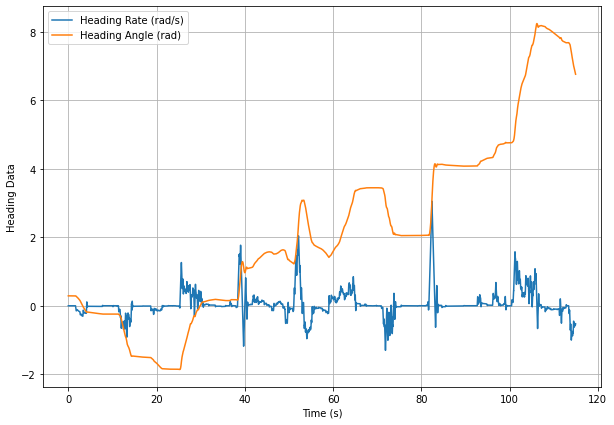

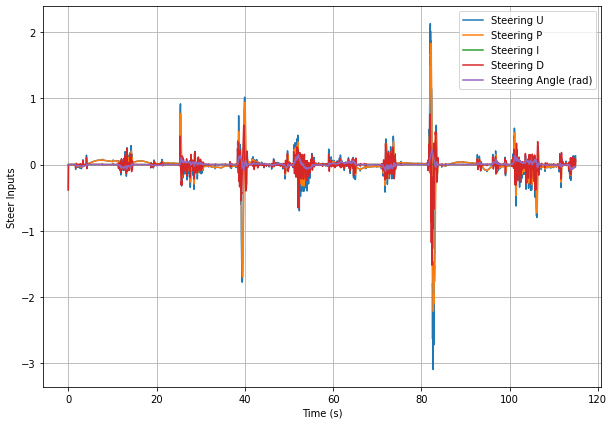

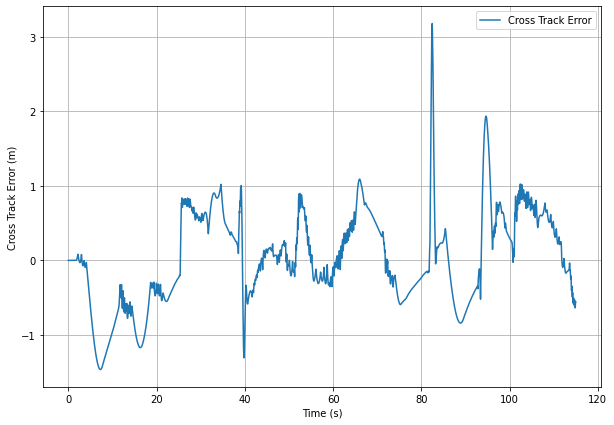

In [ ]:
# show some of the data
plt.plot(car.log_df['Time (s)'], car.log_df['Heading Rate (rads/s)'], label='Heading Rate (rad/s)')
plt.plot(car.log_df['Time (s)'], car.log_df['Heading Angle (rads)'], label='Heading Angle (rad)')
# plt.plot(car.log_df['Time (s)'], car.log_df['Desired Heading (rads)'], label='Desired Heading (rad)')
plt.ylabel('Heading Data')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()


# plt.plot(car.log_df['Time (s)'], car.log_df['Steering Rate (rads/s)'], label='Steering Rate (rad/s)')
plt.plot(car.log_df['Time (s)'], car.log_df['Steering PID-Input'], label='Steering U')
plt.plot(car.log_df['Time (s)'], car.log_df['Steering P-Input'], label='Steering P')
plt.plot(car.log_df['Time (s)'], car.log_df['Steering I-Input'], label='Steering I')
plt.plot(car.log_df['Time (s)'], car.log_df['Steering D-Input'], label='Steering D')
plt.plot(car.log_df['Time (s)'], car.log_df['Steering Angle (rads)'], label='Steering Angle (rad)')
plt.ylabel('Steer Inputs')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

plt.plot(car.log_df['Time (s)'], ctes, label='Cross Track Error')
plt.legend()
plt.ylabel('Cross Track Error (m)')
plt.xlabel('Time (s)')
plt.grid()
plt.show()

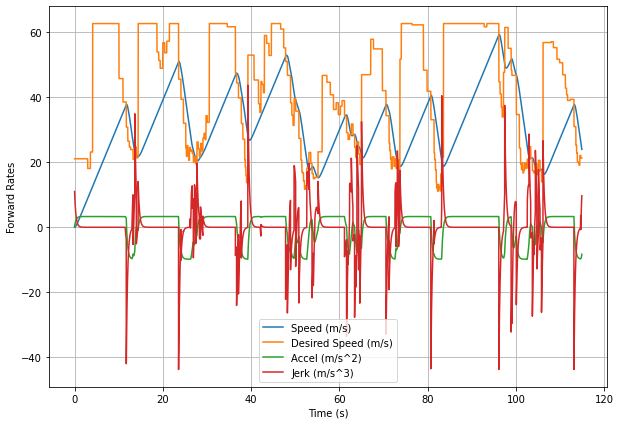

In [ ]:
# plt.plot(times, xs, label='X Pos')
plt.plot(car.log_df['Time (s)'], car.log_df['Speed (m/s)'], label='Speed (m/s)')
plt.plot(car.log_df['Time (s)'], car.log_df['Desired Speed (m/s)'], label='Desired Speed (m/s)')
plt.plot(car.log_df['Time (s)'], car.log_df['Acceleration (m/s^2)'], label='Accel (m/s^2)')
plt.plot(car.log_df['Time (s)'], car.log_df['Jerk (m/s^3)'], label='Jerk (m/s^3)')
plt.ylabel('Forward Rates')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

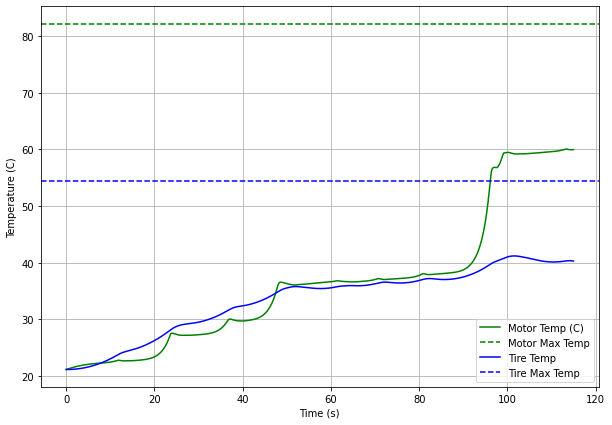

In [ ]:
plt.plot(car.log_df['Time (s)'], car.log_df['Motor Temp (C)'], label='Motor Temp (C)', color='g')
plt.axhline(y = car.motor.max_temp, color = 'g', linestyle = '--', label='Max Motor Temp')
plt.plot(car.log_df['Time (s)'], car.log_df['Tire Temp (C)'], label='Tire Temp', color='b')
plt.axhline(y = car.tire.max_temp, color = 'b', linestyle = '--', label='Max Tire Temp')
plt.legend()
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')
plt.grid()
plt.show()

In [ ]:
# plot the whole track and show the position - this is very inefficient and takes quite a while unfortunately
#track.plot_track(points=poss, point_formats=['r.'])

In [ ]:
# plot the whole track but only show a portion of it
#track.plot_track(points=poss, point_formats=['r.'], window_center=[50,-50], window_size=150)